# Understanding details about how Langosco et al.'s nets work
Let's understand lots of details about [the goal misgeneralization paper](). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, any portions of the state separated by `n` pixels take **??** convolutional layers to interact.
2. In the maximal maze size of **??**, there is at most two steps of computation involving information from e.g. opposite corners of the maze. 

In [1]:
# %% Don't have to restart kernel and reimport each time you modify a dependency
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable
import re 

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output
from ipywidgets import Text, interact, IntSlider, fixed, FloatSlider, Dropdown
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import procgen_tools.models as models
from experiments.patch_utils import *

# %% 
# Load two levels and get values
import pickle as pkl
from procgen import ProcgenGym3Env

rand_region = 5
# Check whether we're in jupyter
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
path_prefix = '../' if in_jupyter else ''

# %%
# Load model

policy = models.load_policy(path_prefix + f'trained_models/maze_I/model_rand_region_{rand_region}.pth', 15,
    t.device('cpu'))

# %% Experiment parameters
label = 'embedder.block2.res1.resadd_out'
interesting_coeffs = np.linspace(-2/3,2/3,10) 
hook = cmh.ModuleHook(policy)

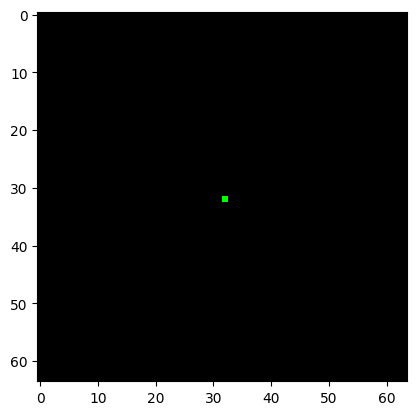

In [ ]:
# Let's load a dummy observation with only one nonzero value
# This is the same as the one used in rollout-patch.py
obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
obs[0, 1, 32,32] = 1 # Have one pixel in the middle, in the "red" channel

# Show obs as an RGB image
plt.imshow(obs[0].transpose(1,2,0))

In [ ]:
def dummy_obs(color: str, location: Tuple[int, int]=(32,32)):
    """ Return two mostly-black images, with the first containing a red/green/blue pixel in the center. Returns shape (2, 3, 64, 64). """
    
    assert color in ['R', 'G', 'B'], f'Color must be one of R, G, B, not {color}'
    assert len(location) == 2, 'Location must be a tuple of length 2'
    assert all(0 <= x < 64 for x in location), 'Location must be in [0, 64)'

    channel = {'R': 0, 'G': 1, 'B': 2}[color]
    dummy_obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
    dummy_obs[0, channel, location[0], location[1]] = 1 # Have one pixel in the middle, in the given channel
    return dummy_obs

In [10]:
# Let's visualize the convolution activations at each layer. First we have to get the relevant layers
hook.probe_with_input(dummy_obs("R"))
labels = list(hook.values_by_label.keys()) 
labels.remove('_out')
# Use regex to check whether the label contains 'conv' and 'out', with an optional number in between
conv_labels = [l for l in labels if re.match(r'.*conv.*out.*', l)]
print(conv_labels)

['embedder.block1.conv_in0', 'embedder.block1.conv_out', 'embedder.block1.maxpool_out', 'embedder.block1.res1.relu1_out', 'embedder.block1.res1.conv1_out', 'embedder.block1.res1.relu2_out', 'embedder.block1.res1.conv2_out', 'embedder.block1.res1.resadd_out', 'embedder.block1.res2.relu1_out', 'embedder.block1.res2.conv1_out', 'embedder.block1.res2.relu2_out', 'embedder.block1.res2.conv2_out', 'embedder.block1.res2.resadd_out', 'embedder.block2.conv_out', 'embedder.block2.maxpool_out', 'embedder.block2.res1.relu1_out', 'embedder.block2.res1.conv1_out', 'embedder.block2.res1.relu2_out', 'embedder.block2.res1.conv2_out', 'embedder.block2.res1.resadd_out', 'embedder.block2.res2.relu1_out', 'embedder.block2.res2.conv1_out', 'embedder.block2.res2.relu2_out', 'embedder.block2.res2.conv2_out', 'embedder.block2.res2.resadd_out', 'embedder.block3.conv_out', 'embedder.block3.maxpool_out', 'embedder.block3.res1.relu1_out', 'embedder.block3.res1.conv1_out', 'embedder.block3.res1.relu2_out', 'embedde

In [32]:
# Now that we have the conv labels, let's visualize the activations at each one using plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_activation_diffs(label: str, channel: int, obs: np.ndarray, fig: go.Figure=None):
    """ Plot the activations of a given channel at a given layer, taking in an obs of shape (2,3,64,64). """
    # Get the activations
    assert obs.shape == (2,3,64,64), f"Obs must be of shape (2,3,64,64), not {obs.shape}"
    hook.probe_with_input(obs) # Run the model with the given obs
    activations = hook.get_value_by_label(label) # Shape is (b, c, h, w)
    diff_activations = activations[0] - activations[1] # Subtract in order to cancel out bias terms which don't behave differently in the presence of our 1/0 discrepancy on the input

    # Ensure there's a fixed green/red colorscale, centered at white=0
    assert channel < activations.shape[1], "Channel doesn't exist at this layer"
    if fig is None: fig = go.Figure()
    fig.add_traces(go.Heatmap(z=diff_activations[channel]))

    # Set the min and max to be the min and max of all channels at this label
    bounds = np.abs(diff_activations).max()
    fig.update_traces(zmin=-1 * bounds, zmid=0, zmax=bounds)

    # Change the colorscale to split red (negative) -- white (zero) -- blue (positive)
    fig.update_traces(colorscale='RdBu')
    
    fig.update_layout(height=500, width=500, title_text=label)
    fig.show() # TODO fix rendering problem

channel_slider = IntSlider(min=0, max=127, step=1, value=0)
@interact 
def plot_activations_interactive(label=Dropdown(options=labels), channel=channel_slider, dummy_color=Dropdown(options=["R","G","B"]), x=IntSlider(min=0, max=63, step=1, value=32), y=IntSlider(min=0, max=63, step=1, value=32)):
    # Set max channel to be the max channel at this layer
    channel_slider.max = hook.get_value_by_label(label).shape[1] - 1
    # Ensure that the figure only displays once in the output
    clear_output()

    plot_activation_diffs(label=label, channel=channel, obs=dummy_obs(dummy_color, (x,y)))

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_in0', 'embedder.block1.conv…

The difference between the two images is:



KeyboardInterrupt



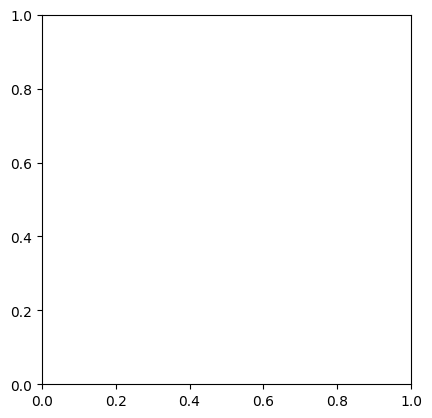

In [42]:
# Load up a cheese/no-cheese maze pair 
from experiments.patch_utils import *
from PIL import Image

seed = 0
venv = get_cheese_venv_pair(seed=seed)
obs = venv.reset()
obs = np.array(obs, dtype=np.float32)

# Show the diff of the RGB renders
print("The difference between the two images is:")
plt.imshow(rearrange(obs[0]-obs[1], 'c h w -> h w c'))

In [41]:
# Visualize the activations at each layer, given this observation difference
channel_slider = IntSlider(min=0, max=127, step=1, value=0)
@interact
def plot_activations_interactive(label=Dropdown(options=labels), channel=channel_slider):
    # Set max channel to be the max channel at this layer
    channel_slider.max = hook.get_value_by_label(label).shape[1] - 1
    # Ensure that the figure only displays once in the output
    clear_output()

    plot_activation_diffs(label=label, channel=channel, obs=obs)

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_in0', 'embedder.block1.conv…